In [44]:
import pandas as pd
import numpy as np, pandas as pd
from scipy import stats
from shapely.geometry import Point, Polygon, MultiPolygon, LineString
import geopandas as gpd
from geopandas import GeoDataFrame
import warnings
import hashlib
import h3
from h3 import h3
import json
from shapely.ops import unary_union
import matplotlib.pyplot as plt
import matplotlib.cm as cm

### Introduction 
In this notebook, we will work with a dataset of Chicago's community areas. Our goal is to create hexagons based on this dataset. We will develop two functions: `hexagonize_geodataframe`, which generates hexagons of a specified size, and `assign_hexagons_to_areas`, which assigns the generated hexagons back to the community areas through a spatial join.

In [45]:
# Read the GeoJSON file of the Chicago Community Areas
geojson_file = "../Datasets/Boundaries - Community Areas.geojson"
gdf = gpd.read_file(geojson_file)
gdf.head()

community area     shape_area perimeter area_num_1 area_numbe  \
0          DOUGLAS    0  46004621.1581         0         35         35   
1          OAKLAND    0  16913961.0408         0         36         36   
2      FULLER PARK    0  19916704.8692         0         37         37   
3  GRAND BOULEVARD    0  48492503.1554         0         38         38   
4          KENWOOD    0  29071741.9283         0         39         39   

  comarea_id comarea      shape_len  \
0          0       0  31027.0545098   
1          0       0  19565.5061533   
2          0       0  25339.0897503   
3          0       0  28196.8371573   
4          0       0  23325.1679062   

                                            geometry  
0  MULTIPOLYGON (((-87.60914 41.84469, -87.60915 ...  
1  MULTIPOLYGON (((-87.59215 41.81693, -87.59231 ...  
2  MULTIPOLYGON (((-87.62880 41.80189, -87.62879 ...  
3  MULTIPOLYGON (((-87.60671 41.81681, -87.60670 ...  
4  MULTIPOLYGON (((-87.59215 41.81693, -87.59215 ...

In [46]:
community_areas = gdf

In [67]:
community_areas.head()

community area     shape_area perimeter area_num_1 area_numbe  \
0          DOUGLAS    0  46004621.1581         0         35         35   
1          OAKLAND    0  16913961.0408         0         36         36   
2      FULLER PARK    0  19916704.8692         0         37         37   
3  GRAND BOULEVARD    0  48492503.1554         0         38         38   
4          KENWOOD    0  29071741.9283         0         39         39   

  comarea_id comarea      shape_len  \
0          0       0  31027.0545098   
1          0       0  19565.5061533   
2          0       0  25339.0897503   
3          0       0  28196.8371573   
4          0       0  23325.1679062   

                                            geometry  
0  MULTIPOLYGON (((-87.60914 41.84469, -87.60915 ...  
1  MULTIPOLYGON (((-87.59215 41.81693, -87.59231 ...  
2  MULTIPOLYGON (((-87.62880 41.80189, -87.62879 ...  
3  MULTIPOLYGON (((-87.60671 41.81681, -87.60670 ...  
4  MULTIPOLYGON (((-87.59215 41.81693, -87.59215 ...

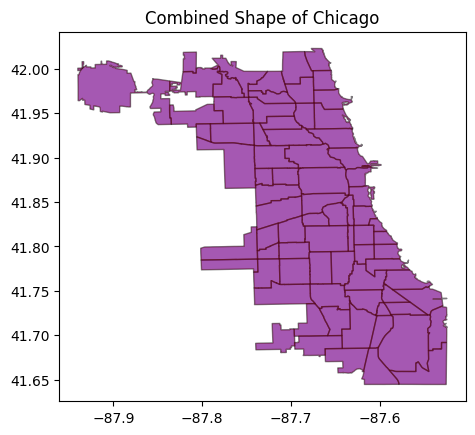

In [47]:
# Combine all the community areas into one shape (union of all geometries)
chicago_shape = unary_union(gdf['geometry'])

# Plot to visualize the combined shape
fig, ax = plt.subplots()
gdf.plot(ax=ax, color='blue', alpha=0.5, edgecolor='k')
gpd.GeoSeries([chicago_shape]).plot(ax=ax, color='red', alpha=0.3)
plt.title('Combined Shape of Chicago')
plt.show()


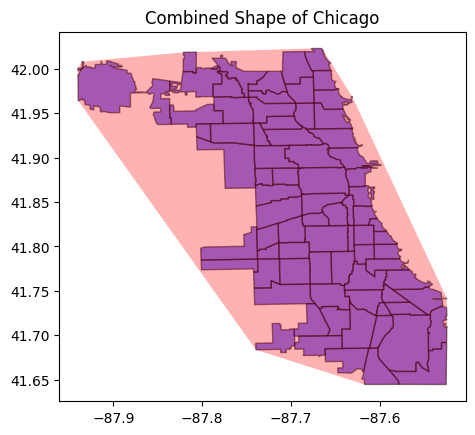

In [48]:
# Create the convex hull of the combined shape
chicago_shape_convex_hull = chicago_shape.convex_hull

# Plot to visualize the combined shape
fig, ax = plt.subplots()
gdf.plot(ax=ax, color='blue', alpha=0.5, edgecolor='k')
gpd.GeoSeries([chicago_shape_convex_hull]).plot(ax=ax, color='red', alpha=0.3)
plt.title('Combined Shape of Chicago')
plt.show()

In [49]:
chicago_shape.geom_type

'MultiPolygon'

In [50]:
# Define the function to convert geometries to hexagons
def hexagonize_geodataframe(geometry, hex_size):
    """
    Convert a geometry to hexagons.
    
    Parameters:
    geometry (shapely.geometry): Input geometry to convert.
    hex_size (int): The hexagon size parameter for h3.
    
    Returns:
    GeoDataFrame: A GeoDataFrame with hexagonal cells.
    """
    hexagons = set()
    if isinstance(geometry, (Polygon, MultiPolygon)):
        # If it's a MultiPolygon, iterate over each Polygon
        if isinstance(geometry, MultiPolygon):
            geometries = geometry.geoms
        else:
            geometries = [geometry]
        
        for geom in geometries:
            if geom.is_empty:
                continue
            # Get the hexagons for the current geometry
            hexes = h3.polyfill(geom.__geo_interface__, hex_size, geo_json_conformant=True)
            hexagons.update(hexes)
    
    # Convert hexagons to GeoDataFrame
    hex_geometries = [h3.h3_to_geo_boundary(h, geo_json=True) for h in hexagons]
    hex_polygons = [Polygon(hex_geom) for hex_geom in hex_geometries]
    hex_gdf = gpd.GeoDataFrame(geometry=hex_polygons)
    
    return hex_gdf

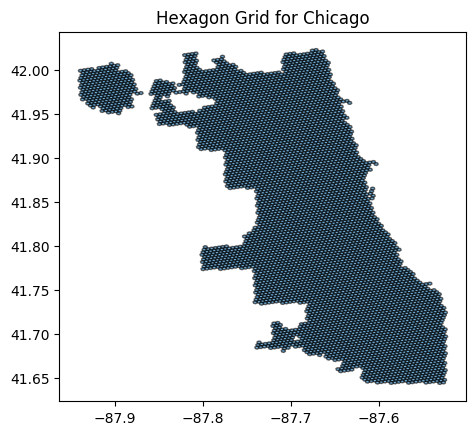

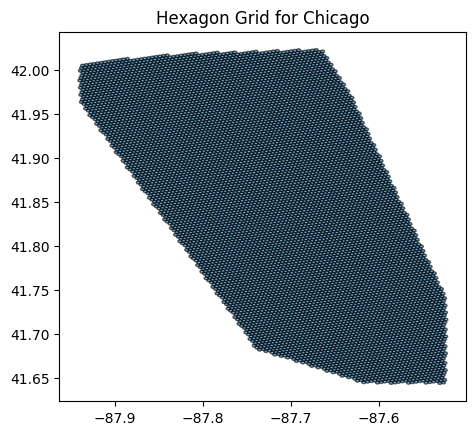

                                            geometry
0  POLYGON ((-87.54246 41.65847, -87.54427 41.657...
1  POLYGON ((-87.65690 41.85444, -87.65871 41.853...
2  POLYGON ((-87.75890 41.89394, -87.76072 41.892...
3  POLYGON ((-87.56805 41.72832, -87.56986 41.727...
4  POLYGON ((-87.67852 41.85943, -87.68033 41.858...


In [51]:
# Example usage for the entire city
hex_size = 9  # Example hexagon size
chicago_hex_gdf = hexagonize_geodataframe(chicago_shape, hex_size)
chicago_hex_gdf_convex_hull = hexagonize_geodataframe(chicago_shape_convex_hull, hex_size)

# Plot to visualize the hexagons
fig, ax = plt.subplots()
chicago_hex_gdf.plot(ax=ax, edgecolor='k', alpha=0.6)
plt.title('Hexagon Grid for Chicago')
plt.show()

# Plot to visualize the hexagons
fig, ax = plt.subplots()
chicago_hex_gdf_convex_hull.plot(ax=ax, edgecolor='k', alpha=0.6)
plt.title('Hexagon Grid for Chicago')
plt.show()

# Display the first few rows of the hexagon GeoDataFrame
print(chicago_hex_gdf.head())

In [52]:
# Function to assign hexagons to community areas
def assign_hexagons_to_areas(hex_gdf, areas_gdf):
    """
    Assign hexagons to community areas.
    
    Parameters:
    hex_gdf (GeoDataFrame): GeoDataFrame containing hexagons.
    areas_gdf (GeoDataFrame): GeoDataFrame containing community areas.
    
    Returns:
    GeoDataFrame: A GeoDataFrame with hexagons and their corresponding community area.
    """
    # Perform a spatial join to assign hexagons to community areas
    joined_gdf = gpd.sjoin(hex_gdf, areas_gdf, how='left')
    return joined_gdf

In [53]:
# Assign hexagons to community areas
assigned_hex_gdf = assign_hexagons_to_areas(chicago_hex_gdf, gdf)
assigned_hex_gdf_convex_hull = assign_hexagons_to_areas(chicago_hex_gdf_convex_hull, gdf)

/var/folders/x4/q675smv52q76wfncl4h9040h0000gn/T/ipykernel_8940/440296932.py:14: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  joined_gdf = gpd.sjoin(hex_gdf, areas_gdf, how='left')
/var/folders/x4/q675smv52q76wfncl4h9040h0000gn/T/ipykernel_8940/440296932.py:14: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  joined_gdf = gpd.sjoin(hex_gdf, areas_gdf, how='left')


In [54]:
#Drop Duplicates
assigned_hex_gdf = assigned_hex_gdf.drop_duplicates(subset=['geometry'])
assigned_hex_gdf_convex_hull = assigned_hex_gdf_convex_hull.drop_duplicates(subset=['geometry'])

In [55]:
assigned_hex_gdf_convex_hull['community'].fillna('Outside Chicago', inplace=True)

/var/folders/x4/q675smv52q76wfncl4h9040h0000gn/T/ipykernel_8940/2140930817.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  assigned_hex_gdf_convex_hull['community'].fillna('Outside Chicago', inplace=True)


                                            geometry  index_right  \
0  POLYGON ((-87.54246 41.65847, -87.54427 41.657...           53   
1  POLYGON ((-87.65690 41.85444, -87.65871 41.853...           32   
2  POLYGON ((-87.75890 41.89394, -87.76072 41.892...           25   
3  POLYGON ((-87.56805 41.72832, -87.56986 41.727...           45   
4  POLYGON ((-87.67852 41.85943, -87.68033 41.858...           32   

         community area     shape_area perimeter area_num_1 area_numbe  \
0        HEGEWISCH    0  145965741.437         0         55         55   
1  LOWER WEST SIDE    0  81550723.6377         0         31         31   
2           AUSTIN    0  199254203.427         0         25         25   
3  CALUMET HEIGHTS    0  48826241.5643         0         48         48   
4  LOWER WEST SIDE    0  81550723.6377         0         31         31   

  comarea_id comarea      shape_len  
0          0       0  73692.3821322  
1          0       0  43229.3727036  
2          0       0  7522

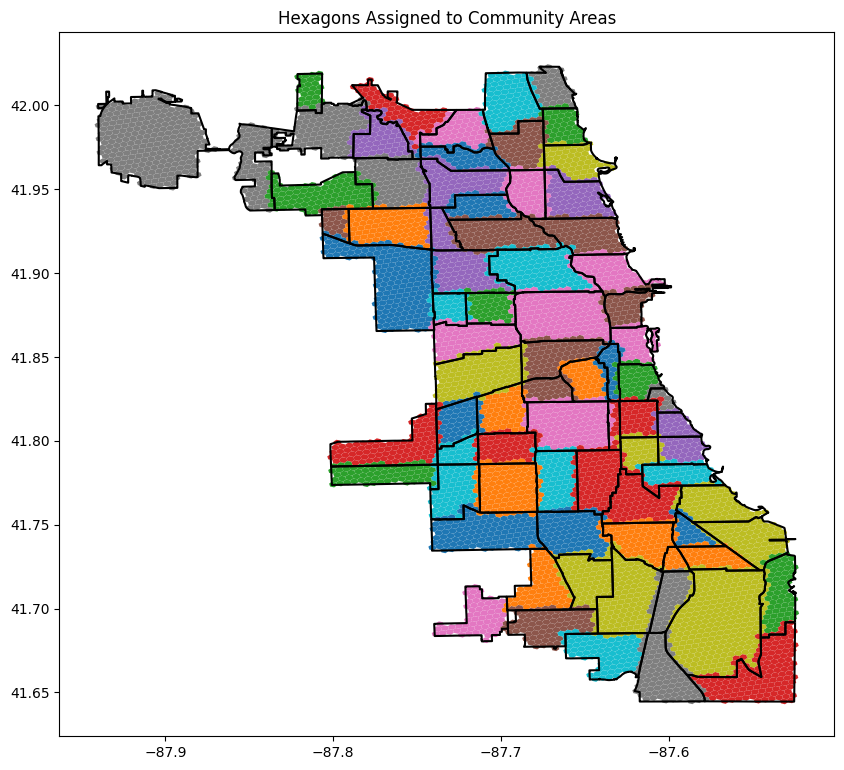

In [56]:
# Display the first few rows of the assigned hexagons GeoDataFrame
print(assigned_hex_gdf.head())

# Plot to visualize the hexagons with community areas
fig, ax = plt.subplots(figsize=(10, 10))
gdf.boundary.plot(ax=ax, color='black')
assigned_hex_gdf.plot(ax=ax, column='community')
plt.title('Hexagons Assigned to Community Areas')
plt.show()

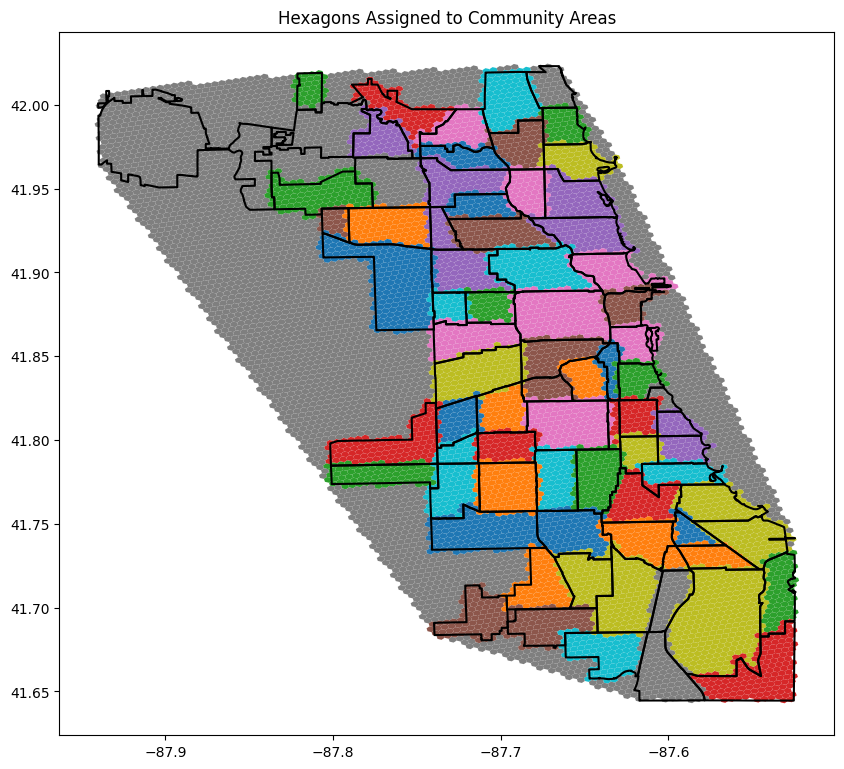

In [57]:
# Plot to visualize the hexagons with community areas
fig, ax = plt.subplots(figsize=(10, 10))
gdf.boundary.plot(ax=ax, color='black')
assigned_hex_gdf_convex_hull.plot(ax=ax, column='community')
plt.title('Hexagons Assigned to Community Areas')
plt.show()

### Showcase of the top 5 farest rides

In [94]:
data = pd.read_pickle("../Datasets/taxi_trips_with_weather_cleaned.pkl")
data.head()

trip_id                           taxi_id  \
0  0cd46aa628ea5f871630113eb8ba92e4  09a6eaba341c43fc653756deff43a50f   
1  4fbe84436a116f11c51ef3306e7adf0c  0f66b306ebea0f05dd124bf958729b64   
2  08a197de2703972bad8877628b18bb30  5a3410255ea0041b967e74090838b14d   
3  94f8c8a4624a061988e0f32e12be04c5  3049f212da83687eb7ea5cb9d3046d89   
4  dd25d5229b1ce93ea03b7c9357e6f4f9  d9d9d16f34141de38105a060abd8a90c   

  timestamp_start       timestamp_end  duration  distance   fare  tips  tolls  \
0      2020-01-01 2020-01-01 00:15:00     180.0      0.64   4.50  0.00    0.0   
1      2020-01-01 2020-01-01 00:30:00    1723.0      1.13  12.00  0.00    0.0   
2      2020-01-01 2020-01-01 00:00:00     420.0      0.97   6.00  0.00    0.0   
3      2020-01-01 2020-01-01 00:30:00    1320.0      8.21  16.75  3.85    0.0   
4      2020-01-01 2020-01-01 00:15:00     504.0      1.19   6.25  0.00    0.0   

   extras  ...  dropoff_long                      dropoff_location  \
0     1.0  ...    -87.626211  POINT (-87.6262105324 41.8991556134)   
1     0.0  ...    -87.626215  POINT (-87.6262149064 41.8925077809)   
2     1.0  ...    -87.618868  POINT (-87.6188683546 41.8909220259)   
3     2.0  ...    -87.676356  POINT (-87.6763559892 41.9012069941)   
4     1.0  ...    -87.626215  POINT (-87.6262149064 41.8925077809)   

  temperature  dew_point  humidity wind_speed  wind_gust  pressure  \
0       -2.83      -5.33      83.0       0.48       0.64    1.0088   
1       -2.83      -5.33      83.0       0.48       0.64    1.0088   
2       -2.83      -5.33      83.0       0.48       0.64    1.0088   
3       -2.83      -5.33      83.0       0.48       0.64    1.0088   
4       -2.83      -5.33      83.0       0.48       0.64    1.0088   

  precipitation_rate  precipitation_accumulation  
0                0.0                         0.0  
1                0.0                         0.0  
2                0.0                         0.0  
3                0.0                         0.0  
4                0.0                         0.0  

[5 rows x 27 columns]

In [101]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3130254 entries, 0 to 3130253
Data columns (total 27 columns):
 #   Column                      Dtype         
---  ------                      -----         
 0   trip_id                     object        
 1   taxi_id                     object        
 2   timestamp_start             datetime64[ns]
 3   timestamp_end               datetime64[ns]
 4   duration                    float64       
 5   distance                    float64       
 6   fare                        float64       
 7   tips                        float64       
 8   tolls                       float64       
 9   extras                      float64       
 10  total                       float64       
 11  payment_type                object        
 12  company                     object        
 13  pickup_lat                  float64       
 14  pickup_long                 float64       
 15  pickup_location             object        
 16  dropoff_lat       

In [95]:
TOP_5_Rides = data.nlargest(5, 'distance')

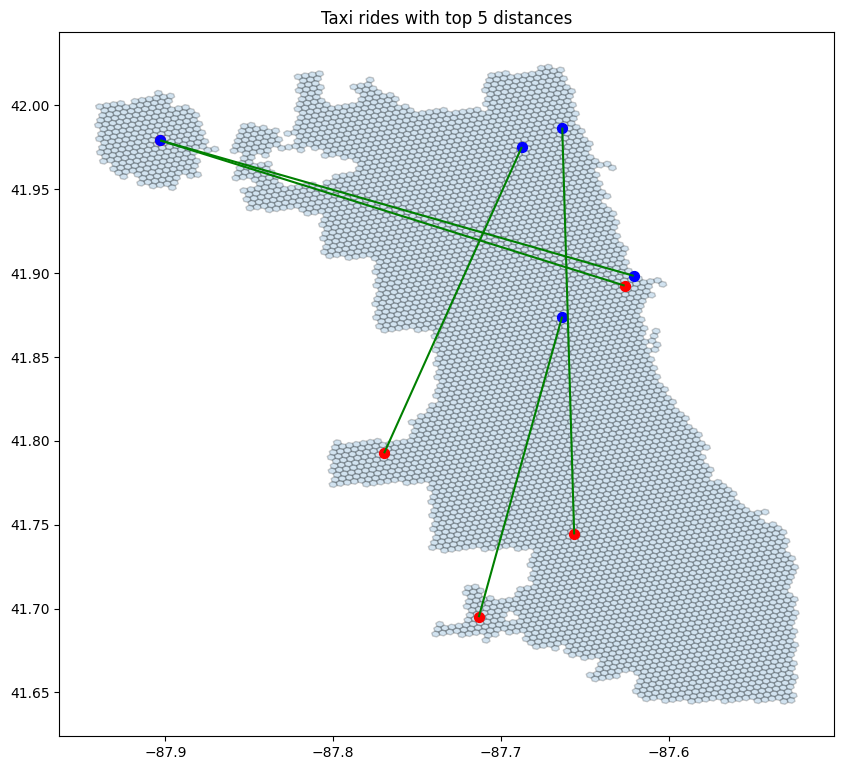

In [96]:
# Get coordinates of the start points and end points
start_points = TOP_5_Rides.apply(lambda row: Point(row['pickup_long'], row['pickup_lat']), axis=1)
end_points = TOP_5_Rides.apply(lambda row: Point(row['dropoff_long'], row['dropoff_lat']), axis=1)

# GDF
start_points_gdf = gpd.GeoDataFrame(geometry=start_points)
end_points_gdf = gpd.GeoDataFrame(geometry=end_points)

# Connect the start and end points with lines
lines = [LineString([start, end]) for start, end in zip(start_points, end_points)]
lines_gdf = gpd.GeoDataFrame(geometry=lines)

# Creat a plot
fig, ax = plt.subplots(figsize=(10, 10))
assigned_hex_gdf.plot(ax=ax, edgecolor='k', alpha=0.2)
start_points_gdf.plot(ax=ax, color='red', markersize=50)
end_points_gdf.plot(ax=ax, color='blue', markersize=50)
lines_gdf.plot(ax=ax, color='green')
plt.title('Taxi rides with top 5 distances')
plt.show()

Check if there are taxi rides that go beyond the existing community centers. Additionally, we will now consider whether it makes sense to create polygons at the city boundary if taxi rides also go there.

In [ ]:
# Get coordinates of the start points and end points
start_points = data.apply(lambda row: Point(row['pickup_long'], row['pickup_lat']), axis=1)
end_points = data.apply(lambda row: Point(row['dropoff_long'], row['dropoff_lat']), axis=1)

# GDF
start_points_gdf = gpd.GeoDataFrame(geometry=start_points)
end_points_gdf = gpd.GeoDataFrame(geometry=end_points)


# Creat a plot
fig, ax = plt.subplots(figsize=(15, 15))
assigned_hex_gdf.plot(ax=ax, edgecolor='k', alpha=0.2)
start_points_gdf.plot(ax=ax, color='red', markersize=20, alpha=0.2)
end_points_gdf.plot(ax=ax, color='blue', markersize=20, alpha=0.2)
plt.title('Taxi rides')
plt.show()

In [ ]:
# Get coordinates of the start points and end points
start_points = data.apply(lambda row: Point(row['pickup_long'], row['pickup_lat']), axis=1)
end_points = data.apply(lambda row: Point(row['dropoff_long'], row['dropoff_lat']), axis=1)

# GDF
start_points_gdf = gpd.GeoDataFrame(geometry=start_points)
end_points_gdf = gpd.GeoDataFrame(geometry=end_points)
# Test if the start points are outside the polygons
start_points_outside = start_points_gdf[~start_points_gdf.geometry.within(assigned_hex_gdf.unary_union)]

# Test if the end points are outside the polygons
end_points_outside = end_points_gdf[~end_points_gdf.geometry.within(assigned_hex_gdf.unary_union)]

# Ploting the points
fig, ax = plt.subplots(figsize=(10, 10))
assigned_hex_gdf.plot(ax=ax, edgecolor='k', alpha=0.6)
start_points_outside.plot(ax=ax, color='red', marker='o', label='Start Points Outside')
end_points_outside.plot(ax=ax, color='blue', marker='o', label='End Points Outside')
plt.legend()
plt.title('Start and End Points Outside Assigned Hexagons')
plt.show()

In [ ]:
print("start_points_outside")
print(start_points_outside)
print("end_points_outside")
print(end_points_outside)

### Joining POIs to the hexagon map

In [58]:
# Read the GeoJSON file of the Chicago POIs
geojson_file = "../Datasets/POI.geojson"
POI_BIG = gpd.read_file(geojson_file)
POI_BIG.head()

id             @id access addr:city addr:country addr:floor  \
0  node/271275603  node/271275603   None      None         None       None   
1  node/306741002  node/306741002   None   Chicago         None       None   
2  node/311438932  node/311438932   None      None         None       None   
3  node/313107974  node/313107974   None   Chicago         None       None   
4  node/318274065  node/318274065   None   Chicago         None       None   

  addr:full addr:housename addr:housenumber addr:place  ...  \
0      None           None             None       None  ...   
1      None           None              600       None  ...   
2      None           None             None       None  ...   
3      None           None              700       None  ...   
4      None           None               61       None  ...   

                                             website website:menu  \
0                                               None         None   
1                                               None         None   
2                          https://neofuturists.org/         None   
3            https://www.imax.com/oo/navy-pier-imax/         None   
4  https://www.pizanoschicago.com/locations/chica...         None   

  website:store wheelchair wheelchair:description  wifi   wikidata  \
0          None       None                   None  None       None   
1          None        yes                   None  None       None   
2          None       None                   None  None  Q16254317   
3          None       None                   None  None  Q37760649   
4          None       None                   None  None       None   

          wikipedia  yelp                    geometry  
0              None  None  POINT (-87.62551 41.88481)  
1              None  None  POINT (-87.60966 41.89141)  
2  en:Neo-Futurists  None  POINT (-87.66933 41.97579)  
3              None  None  POINT (-87.60924 41.89190)  
4              None  None  POINT (-87.62567 41.88198)  

[5 rows x 217 columns]

In [59]:
POI = POI_BIG[['id', 'name', 'amenity', 'geometry']]
POI.head()

id                       name     amenity  \
0  node/271275603         Storefront Theater     theatre   
1  node/306741002  Bubba Gump Shrimp Company  restaurant   
2  node/311438932               Neofuturists     theatre   
3  node/313107974     Navy Pier IMAX Theatre      cinema   
4  node/318274065     Pizano's Pizza & Pasta  restaurant   

                     geometry  
0  POINT (-87.62551 41.88481)  
1  POINT (-87.60966 41.89141)  
2  POINT (-87.66933 41.97579)  
3  POINT (-87.60924 41.89190)  
4  POINT (-87.62567 41.88198)

In [60]:
POI.info()
POI.geometry

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 4111 entries, 0 to 4110
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   id        4111 non-null   object  
 1   name      4095 non-null   object  
 2   amenity   3862 non-null   object  
 3   geometry  4111 non-null   geometry
dtypes: geometry(1), object(3)
memory usage: 128.6+ KB


0       POINT (-87.62551 41.88481)
1       POINT (-87.60966 41.89141)
2       POINT (-87.66933 41.97579)
3       POINT (-87.60924 41.89190)
4       POINT (-87.62567 41.88198)
                   ...            
4106    POINT (-87.65999 41.97335)
4107    POINT (-87.68852 41.92507)
4108    POINT (-87.64110 41.79321)
4109    POINT (-87.62288 41.89308)
4110    POINT (-87.70452 41.92711)
Name: geometry, Length: 4111, dtype: geometry

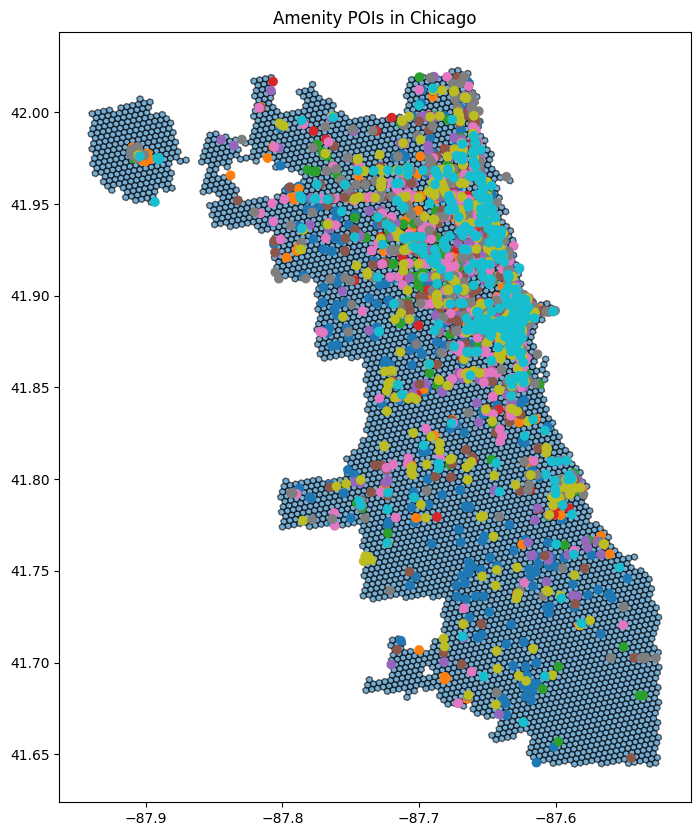

In [61]:
# Plot der POIs
fig, ax = plt.subplots(figsize=(10, 10))
assigned_hex_gdf.plot(ax=ax, edgecolor='k', alpha=0.6)
POI.plot(ax=ax, c=POI["amenity"], marker='o', cmap='tab10')
plt.title('Amenity POIs in Chicago')
plt.show()

In [62]:
print(POI["amenity"].unique())
POI
POI.info()

['theatre' 'restaurant' 'cinema' 'cafe' 'school' None 'university'
 'library' 'bar' 'clinic']
<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 4111 entries, 0 to 4110
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   id        4111 non-null   object  
 1   name      4095 non-null   object  
 2   amenity   3862 non-null   object  
 3   geometry  4111 non-null   geometry
dtypes: geometry(1), object(3)
memory usage: 128.6+ KB


In [63]:
POI

id                       name     amenity  \
0       node/271275603         Storefront Theater     theatre   
1       node/306741002  Bubba Gump Shrimp Company  restaurant   
2       node/311438932               Neofuturists     theatre   
3       node/313107974     Navy Pier IMAX Theatre      cinema   
4       node/318274065     Pizano's Pizza & Pasta  restaurant   
...                ...                        ...         ...   
4106  node/11895741748           Fat Miilk Uptown        cafe   
4107  node/11896854143          Fry Like An Eagle  restaurant   
4108  node/11910937404    KIPP Bllom College Prep      school   
4109  node/11916788470                  Starbucks        cafe   
4110  node/11916865925                      KFire  restaurant   

                        geometry  
0     POINT (-87.62551 41.88481)  
1     POINT (-87.60966 41.89141)  
2     POINT (-87.66933 41.97579)  
3     POINT (-87.60924 41.89190)  
4     POINT (-87.62567 41.88198)  
...                          ...  
4106  POINT (-87.65999 41.97335)  
4107  POINT (-87.68852 41.92507)  
4108  POINT (-87.64110 41.79321)  
4109  POINT (-87.62288 41.89308)  
4110  POINT (-87.70452 41.92711)  

[4111 rows x 4 columns]

In [64]:
# Joining the POIs to the hexagons
assigned_hex_gdf.rename(columns={'index_right': 'assigned_index_right'}, inplace=True)
assigned_hex_gdf_poi = gpd.sjoin(assigned_hex_gdf, POI, how='left', op='intersects')
assigned_hex_gdf_poi

/Users/finnreinders/anaconda3/envs/AAA/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
/var/folders/x4/q675smv52q76wfncl4h9040h0000gn/T/ipykernel_8940/1267277940.py:3: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  assigned_hex_gdf_poi = gpd.sjoin(assigned_hex_gdf, POI, how='left', op='intersects')


geometry  assigned_index_right  \
0     POLYGON ((-87.54246 41.65847, -87.54427 41.657...                    53   
1     POLYGON ((-87.65690 41.85444, -87.65871 41.853...                    32   
2     POLYGON ((-87.75890 41.89394, -87.76072 41.892...                    25   
3     POLYGON ((-87.56805 41.72832, -87.56986 41.727...                    45   
4     POLYGON ((-87.67852 41.85943, -87.68033 41.858...                    32   
...                                                 ...                   ...   
5626  POLYGON ((-87.71239 41.98569, -87.71421 41.984...                    12   
5626  POLYGON ((-87.71239 41.98569, -87.71421 41.984...                    12   
5626  POLYGON ((-87.71239 41.98569, -87.71421 41.984...                    12   
5627  POLYGON ((-87.72015 41.99548, -87.72197 41.994...                    12   
5628  POLYGON ((-87.89880 41.98518, -87.90062 41.984...                    74   

            community area     shape_area perimeter area_num_1 area_numbe  \
0           HEGEWISCH    0  145965741.437         0         55         55   
1     LOWER WEST SIDE    0  81550723.6377         0         31         31   
2              AUSTIN    0  199254203.427         0         25         25   
3     CALUMET HEIGHTS    0  48826241.5643         0         48         48   
4     LOWER WEST SIDE    0  81550723.6377         0         31         31   
...               ...  ...            ...       ...        ...        ...   
5626       NORTH PARK    0  70288706.4343         0         13         13   
5626       NORTH PARK    0  70288706.4343         0         13         13   
5626       NORTH PARK    0  70288706.4343         0         13         13   
5627       NORTH PARK    0  70288706.4343         0         13         13   
5628            OHARE    0  371835607.687         0         76         76   

     comarea_id comarea      shape_len  index_right               id  \
0             0       0  73692.3821322          NaN              NaN   
1             0       0  43229.3727036          NaN              NaN   
2             0       0  75226.4749167          NaN              NaN   
3             0       0  32925.3658706          NaN              NaN   
4             0       0  43229.3727036          NaN              NaN   
...         ...     ...            ...          ...              ...   
5626          0       0  41581.9486539       3350.0  node/8094516120   
5626          0       0  41581.9486539       2934.0  node/6324177369   
5626          0       0  41581.9486539        148.0   node/354233394   
5627          0       0  41581.9486539          NaN              NaN   
5628          0       0   173625.98466          NaN              NaN   

                name     amenity  
0                NaN         NaN  
1                NaN         NaN  
2                NaN         NaN  
3                NaN         NaN  
4                NaN         NaN  
...              ...         ...  
5626          Midori  restaurant  
5626    Outdoor Cafe        cafe  
5626  Camelot School      school  
5627             NaN         NaN  
5628             NaN         NaN  

[8476 rows x 15 columns]

In [65]:
"""
Von Data Wrangler generierte Zelle.
"""
def clean_data(assigned_hex_gdf_poi):
    # Ersetzen fehlender Werte durch "NO_AMENITY" in Spalte: 'amenity'
    assigned_hex_gdf_poi = assigned_hex_gdf_poi.fillna({'amenity': "NO_AMENITY"})
    # Gruppiert nach Spalten: 'geometry', 'community', 'amenity'
    assigned_hex_gdf_poi = assigned_hex_gdf_poi.groupby(['geometry', 'community', 'amenity']).count().reset_index()[['geometry', 'community', 'amenity']]
    return assigned_hex_gdf_poi

assigned_hex_gdf_poi_clean = clean_data(assigned_hex_gdf_poi.copy())
assigned_hex_gdf_poi_clean.head()

geometry        community  \
0  POLYGON ((-87.73941 41.68656, -87.74122 41.685...  MOUNT GREENWOOD   
1  POLYGON ((-87.73521 41.68718, -87.73702 41.686...  MOUNT GREENWOOD   
2  POLYGON ((-87.73819 41.68947, -87.74000 41.688...  MOUNT GREENWOOD   
3  POLYGON ((-87.73399 41.69009, -87.73579 41.688...  MOUNT GREENWOOD   
4  POLYGON ((-87.73697 41.69238, -87.73877 41.691...  MOUNT GREENWOOD   

      amenity  
0  NO_AMENITY  
1  NO_AMENITY  
2  NO_AMENITY  
3  NO_AMENITY  
4  NO_AMENITY

In [66]:
df = assigned_hex_gdf_poi_clean.pivot_table(index=['geometry', 'community'], 
                                            values='amenity', 
                                            columns='amenity', 
                                            aggfunc='size', 
                                            fill_value=0)
df

amenity                                                            NO_AMENITY  \
geometry                                          community                     
POLYGON ((-87.73941 41.68656, -87.74122 41.685... MOUNT GREENWOOD           1   
POLYGON ((-87.73521 41.68718, -87.73702 41.686... MOUNT GREENWOOD           1   
POLYGON ((-87.73819 41.68947, -87.74000 41.688... MOUNT GREENWOOD           1   
POLYGON ((-87.73399 41.69009, -87.73579 41.688... MOUNT GREENWOOD           1   
POLYGON ((-87.73697 41.69238, -87.73877 41.691... MOUNT GREENWOOD           1   
...                                                                       ...   
POLYGON ((-87.53182 41.64641, -87.53363 41.645... HEGEWISCH                 1   
POLYGON ((-87.53058 41.64931, -87.53240 41.648... HEGEWISCH                 1   
POLYGON ((-87.52935 41.65222, -87.53116 41.651... HEGEWISCH                 1   
POLYGON ((-87.52638 41.64993, -87.52819 41.648... HEGEWISCH                 1   
POLYGON ((-87.52761 41.64702, -87.52943 41.645... HEGEWISCH                 1   

amenity                                                            bar  cafe  \
geometry                                          community                    
POLYGON ((-87.73941 41.68656, -87.74122 41.685... MOUNT GREENWOOD    0     0   
POLYGON ((-87.73521 41.68718, -87.73702 41.686... MOUNT GREENWOOD    0     0   
POLYGON ((-87.73819 41.68947, -87.74000 41.688... MOUNT GREENWOOD    0     0   
POLYGON ((-87.73399 41.69009, -87.73579 41.688... MOUNT GREENWOOD    0     0   
POLYGON ((-87.73697 41.69238, -87.73877 41.691... MOUNT GREENWOOD    0     0   
...                                                                ...   ...   
POLYGON ((-87.53182 41.64641, -87.53363 41.645... HEGEWISCH          0     0   
POLYGON ((-87.53058 41.64931, -87.53240 41.648... HEGEWISCH          0     0   
POLYGON ((-87.52935 41.65222, -87.53116 41.651... HEGEWISCH          0     0   
POLYGON ((-87.52638 41.64993, -87.52819 41.648... HEGEWISCH          0     0   
POLYGON ((-87.52761 41.64702, -87.52943 41.645... HEGEWISCH          0     0   

amenity                                                            cinema  \
geometry                                          community                 
POLYGON ((-87.73941 41.68656, -87.74122 41.685... MOUNT GREENWOOD       0   
POLYGON ((-87.73521 41.68718, -87.73702 41.686... MOUNT GREENWOOD       0   
POLYGON ((-87.73819 41.68947, -87.74000 41.688... MOUNT GREENWOOD       0   
POLYGON ((-87.73399 41.69009, -87.73579 41.688... MOUNT GREENWOOD       0   
POLYGON ((-87.73697 41.69238, -87.73877 41.691... MOUNT GREENWOOD       0   
...                                                                   ...   
POLYGON ((-87.53182 41.64641, -87.53363 41.645... HEGEWISCH             0   
POLYGON ((-87.53058 41.64931, -87.53240 41.648... HEGEWISCH             0   
POLYGON ((-87.52935 41.65222, -87.53116 41.651... HEGEWISCH             0   
POLYGON ((-87.52638 41.64993, -87.52819 41.648... HEGEWISCH             0   
POLYGON ((-87.52761 41.64702, -87.52943 41.645... HEGEWISCH             0   

amenity                                                            clinic  \
geometry                                          community                 
POLYGON ((-87.73941 41.68656, -87.74122 41.685... MOUNT GREENWOOD       0   
POLYGON ((-87.73521 41.68718, -87.73702 41.686... MOUNT GREENWOOD       0   
POLYGON ((-87.73819 41.68947, -87.74000 41.688... MOUNT GREENWOOD       0   
POLYGON ((-87.73399 41.69009, -87.73579 41.688... MOUNT GREENWOOD       0   
POLYGON ((-87.73697 41.69238, -87.73877 41.691... MOUNT GREENWOOD       0   
...                                                                   ...   
POLYGON ((-87.53182 41.64641, -87.53363 41.645... HEGEWISCH             0   
POLYGON ((-87.53058 41.64931, -87.53240 41.648... HEGEWISCH             0   
POLYGON ((-87.52935 41.65222, -87.53116 41.651... HEGEWISCH             0   
POLYGON ((-87.52638 41.64993, -87.52819 41.648... HEGEWI

Here a function is created that can be used to create hexagons with the different POIs and to join them with the community areas

In [73]:
#Creating hexagon grid with POIs for given hexagon size

def create_hexagon_grid_with_pois(hex_size, geometry, poi_gdf, community_areas):
    """
    Create a hexagon grid with POIs for a given hexagon size.
    
    Parameters:
    hex_size (int): The hexagon size parameter for h3.
    hex_gdf (GeoDataFrame): GeoDataFrame containing hexagons.
    poi_gdf (GeoDataFrame): GeoDataFrame containing Points of Interest (POIs).
    
    Returns:
    DataFrame: A DataFrame with hexagons and their corresponding POIs.
    """

    hex_gdf = hexagonize_geodataframe(geometry, hex_size)

    assigned_hex_gdf = assign_hexagons_to_areas(hex_gdf, community_areas)

    assigned_hex_gdf.rename(columns={'index_right': 'assigned_index_right'}, inplace=True)

    # Assign hexagons to POIs
    assigned_hex_gdf_poi = gpd.sjoin(assigned_hex_gdf, poi_gdf, how='left', op='intersects')

    
    
    # Clean the data
    assigned_hex_gdf_poi_clean = clean_data(assigned_hex_gdf_poi)
    
    # Pivot the data
    df = assigned_hex_gdf_poi_clean.pivot_table(index=['geometry', 'community'], 
                                                values='amenity', 
                                                columns='amenity', 
                                                aggfunc='size', 
                                                fill_value=0)
    
    df.reset_index(inplace=True)
    df.columns.name = None
    df = df.rename_axis(None, axis=1)
    
    return df


In [86]:
hex_size_10_pois = create_hexagon_grid_with_pois(10, chicago_shape, POI, gdf)
hex_size_9_pois = create_hexagon_grid_with_pois(9, chicago_shape, POI, gdf)
hex_size_8_pois = create_hexagon_grid_with_pois(8, chicago_shape, POI, gdf)
hex_size_7_pois = create_hexagon_grid_with_pois(7, chicago_shape, POI, gdf)
hex_size_6_pois = create_hexagon_grid_with_pois(6, chicago_shape, POI, gdf)



/var/folders/x4/q675smv52q76wfncl4h9040h0000gn/T/ipykernel_8940/440296932.py:14: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  joined_gdf = gpd.sjoin(hex_gdf, areas_gdf, how='left')
/Users/finnreinders/anaconda3/envs/AAA/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3505: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/var/folders/x4/q675smv52q76wfncl4h9040h0000gn/T/ipykernel_8940/3066033822.py:23: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  assigned_hex_gdf_poi = gpd.sjoin(assigned_hex_g

/var/folders/x4/q675smv52q76wfncl4h9040h0000gn/T/ipykernel_8940/440296932.py:14: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  joined_gdf = gpd.sjoin(hex_gdf, areas_gdf, how='left')
/Users/finnreinders/anaconda3/envs/AAA/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3505: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/var/folders/x4/q675smv52q76wfncl4h9040h0000gn/T/ipykernel_8940/3066033822.py:23: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  assigned_hex_gdf_poi = gpd.sjoin(assigned_hex_g

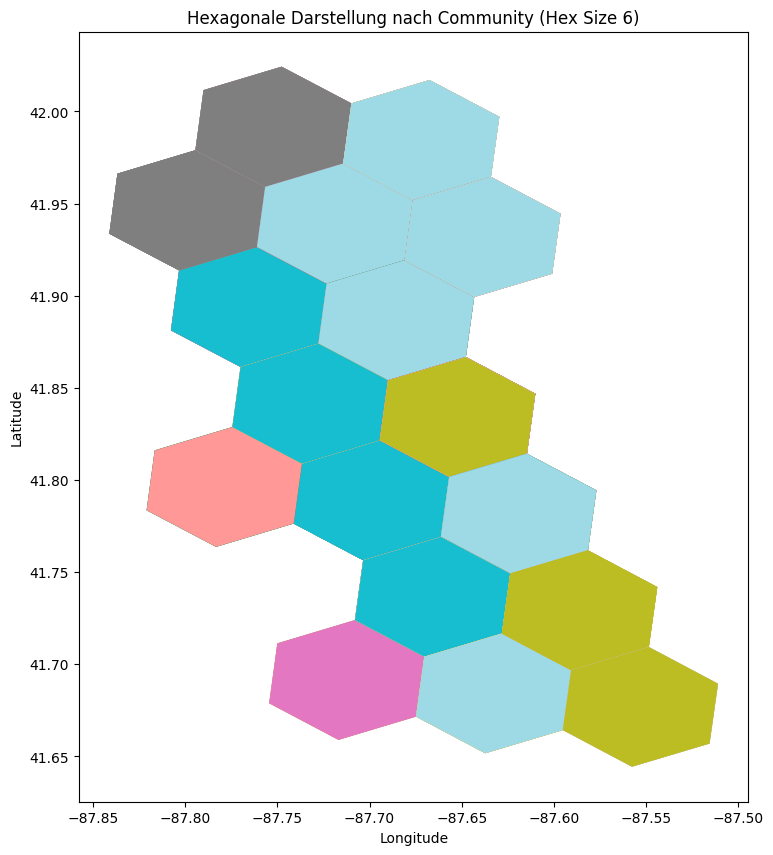

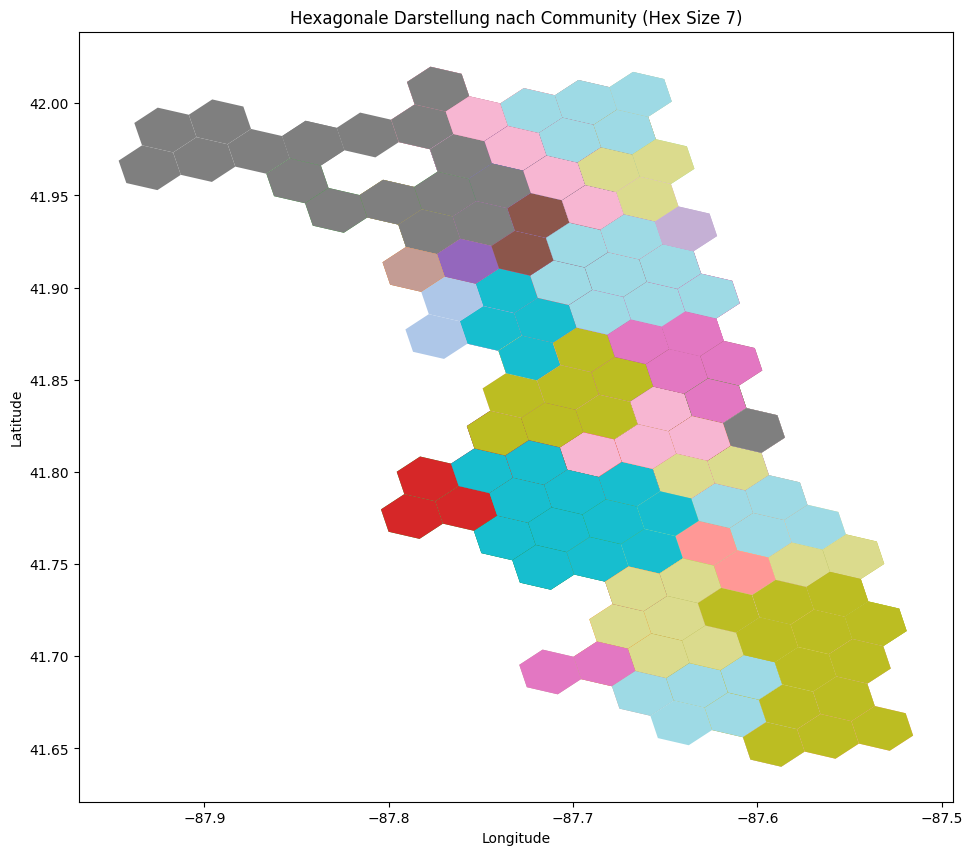

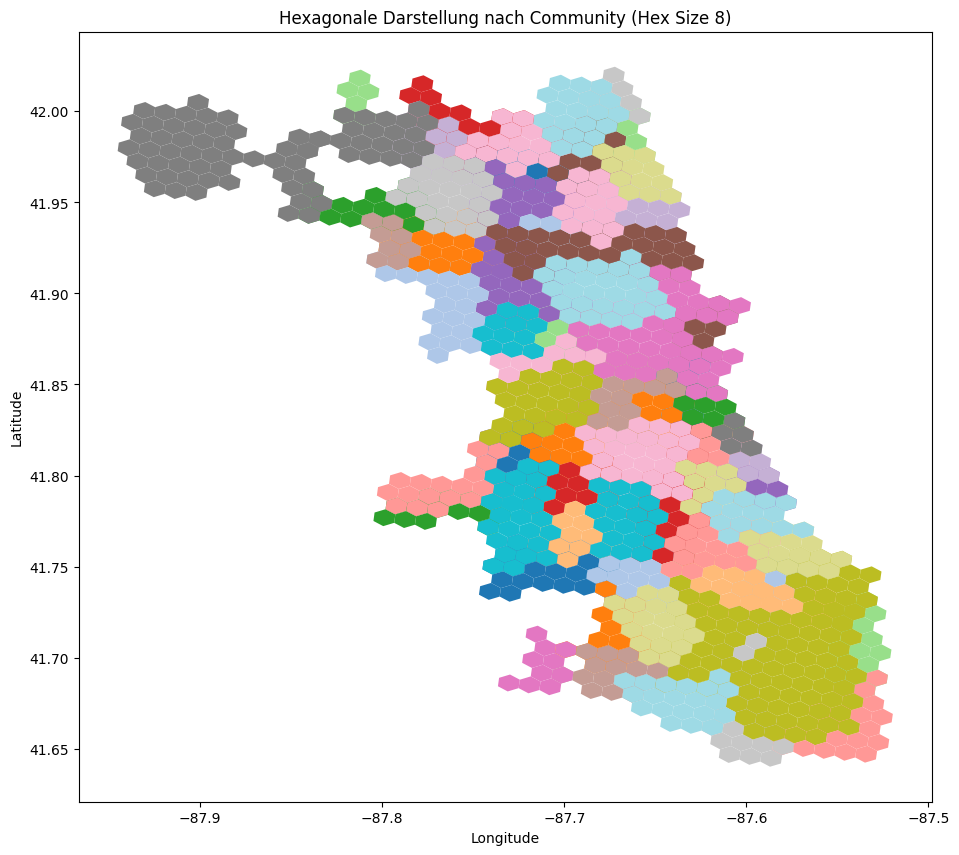

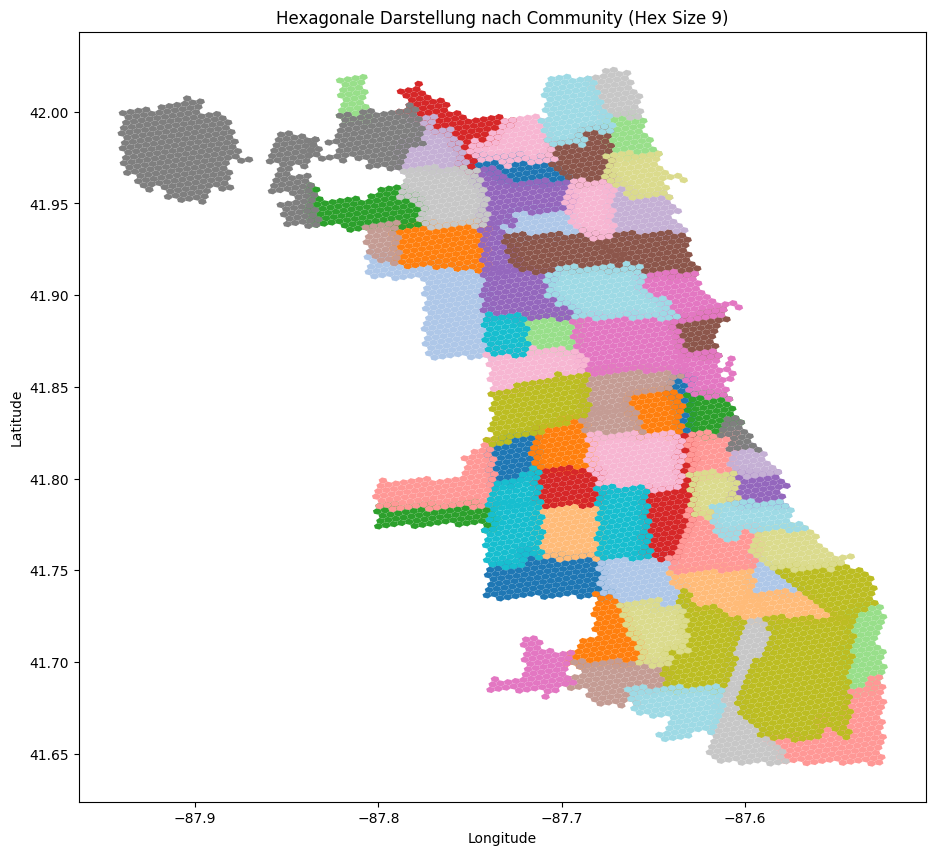

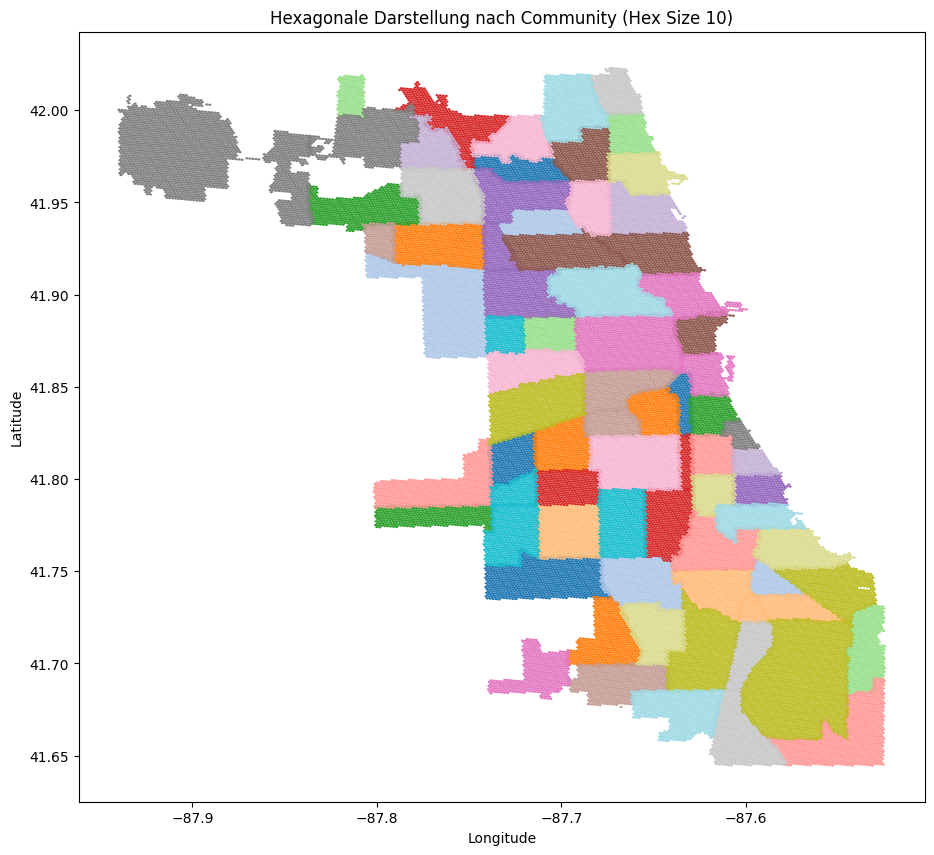

In [91]:
# Erstellen der GeoDataFrames für die verschiedenen hex_sizes
hex_sizes = [6, 7, 8, 9, 10]
geo_dfs = {}

for hex_size in hex_sizes:
    geo_dfs[f"hex_size_{hex_size}_pois"] = create_hexagon_grid_with_pois(hex_size, chicago_shape, POI, gdf)

# Konvertieren der GeoDataFrames und Plotten der Hexagons
for hex_size in hex_sizes:
    # GeoDataFrame konvertieren
    geo_dfs[f"hex_size_{hex_size}_pois"] = gpd.GeoDataFrame(geo_dfs[f"hex_size_{hex_size}_pois"], geometry='geometry')

    # Plotten der Hexagons und Einfärben nach 'community'
    fig, ax = plt.subplots(1, 1, figsize=(15, 10))

    geo_dfs[f"hex_size_{hex_size}_pois"].plot(column='community', ax=ax, legend=False, categorical=True, cmap='tab20')

    # Optional: Titel und Achsenbeschriftungen hinzufügen
    ax.set_title(f'Hexagonale Darstellung nach Community (Hex Size {hex_size})')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')

    # Anzeigen des Plots
    plt.show()

Creating Time Dataframe

In [92]:
def generate_time_series(start_time, end_time, freq_minutes):
    """
    Generate a time series with additional features.
    
    Parameters:
    start_time (str): The start time in 'YYYY-MM-DD HH:MM:SS' format.
    end_time (str): The end time in 'YYYY-MM-DD HH:MM:SS' format.
    freq_minutes (int): Frequency of the time series in minutes.
    
    Returns:
    DataFrame: A DataFrame containing the time series and additional features.
    """
    # Create the time series
    time_series = pd.date_range(start=start_time, end=end_time, freq=f'{freq_minutes}T')
    df = pd.DataFrame(time_series, columns=['datetime'])
    
    # Extract additional features
    df['weekday'] = df['datetime'].dt.dayofweek
    df['month'] = df['datetime'].dt.month
    df['day_of_year'] = df['datetime'].dt.dayofyear
    df['week_of_year'] = df['datetime'].dt.isocalendar().week
    df['quarter'] = df['datetime'].dt.quarter
    df['is_weekend'] = df['weekday'].apply(lambda x: 1 if x >= 5 else 0)
    df['hour'] = df['datetime'].dt.hour
    df['is_month_start'] = df['datetime'].dt.is_month_start
    df['is_month_end'] = df['datetime'].dt.is_month_end
    df['is_quarter_start'] = df['datetime'].dt.is_quarter_start
    df['is_quarter_end'] = df['datetime'].dt.is_quarter_end
    df['is_year_start'] = df['datetime'].dt.is_year_start
    df['is_year_end'] = df['datetime'].dt.is_year_end
    df['is_leap_year'] = df['datetime'].dt.is_leap_year
    
    # Define time of day segments
    def get_time_of_day(hour):
        if hour >= 5 and hour < 12:
            return 'morning'
        elif hour >= 12 and hour < 17:
            return 'afternoon'
        elif hour >= 17 and hour < 21:
            return 'evening'
        else:
            return 'night'
    
    df['time_of_day'] = df['hour'].apply(get_time_of_day)
    
    
    return df



/var/folders/x4/q675smv52q76wfncl4h9040h0000gn/T/ipykernel_8940/3192547577.py:14: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  time_series = pd.date_range(start=start_time, end=end_time, freq=f'{freq_minutes}T')


datetime  weekday  month  day_of_year  week_of_year  quarter  \
0 2020-01-01 00:00:00        2      1            1             1        1   
1 2020-01-01 00:05:00        2      1            1             1        1   
2 2020-01-01 00:10:00        2      1            1             1        1   
3 2020-01-01 00:15:00        2      1            1             1        1   
4 2020-01-01 00:20:00        2      1            1             1        1   

   is_weekend  hour  is_month_start  is_month_end  is_quarter_start  \
0           0     0            True         False              True   
1           0     0            True         False              True   
2           0     0            True         False              True   
3           0     0            True         False              True   
4           0     0            True         False              True   

   is_quarter_end  is_year_start  is_year_end  is_leap_year time_of_day  
0           False           True        False          True       night  
1           False           True        False          True       night  
2           False           True        False          True       night  
3           False           True        False          True       night  
4           False           True        False          True       night

In [93]:
# Example usage
start_time = '2020-01-01 00:00:00'
end_time = '2021-01-01 00:00:00'
freq_minutes = 360

time_series_df = generate_time_series(start_time, end_time, freq_minutes)
time_series_df.head()

/var/folders/x4/q675smv52q76wfncl4h9040h0000gn/T/ipykernel_8940/3192547577.py:14: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  time_series = pd.date_range(start=start_time, end=end_time, freq=f'{freq_minutes}T')


datetime  weekday  month  day_of_year  week_of_year  quarter  \
0 2020-01-01 00:00:00        2      1            1             1        1   
1 2020-01-01 06:00:00        2      1            1             1        1   
2 2020-01-01 12:00:00        2      1            1             1        1   
3 2020-01-01 18:00:00        2      1            1             1        1   
4 2020-01-02 00:00:00        3      1            2             1        1   

   is_weekend  hour  is_month_start  is_month_end  is_quarter_start  \
0           0     0            True         False              True   
1           0     6            True         False              True   
2           0    12            True         False              True   
3           0    18            True         False              True   
4           0     0           False         False             False   

   is_quarter_end  is_year_start  is_year_end  is_leap_year time_of_day  
0           False           True        False          True       night  
1           False           True        False          True     morning  
2           False           True        False          True   afternoon  
3           False           True        False          True     evening  
4           False          False        False          True       night

In [98]:
sixh_8hex = time_series_df.merge(hex_size_8_pois, how='cross')

In [100]:
sixh_8hex.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2014375 entries, 0 to 2014374
Data columns (total 28 columns):
 #   Column            Dtype         
---  ------            -----         
 0   datetime          datetime64[ns]
 1   weekday           int32         
 2   month             int32         
 3   day_of_year       int32         
 4   week_of_year      UInt32        
 5   quarter           int32         
 6   is_weekend        int64         
 7   hour              int32         
 8   is_month_start    bool          
 9   is_month_end      bool          
 10  is_quarter_start  bool          
 11  is_quarter_end    bool          
 12  is_year_start     bool          
 13  is_year_end       bool          
 14  is_leap_year      bool          
 15  time_of_day       object        
 16  geometry          geometry      
 17  community         object        
 18  NO_AMENITY        int64         
 19  bar               int64         
 20  cafe              int64         
 21  cinema  